# 모듈 불러오기 및 버전 확인

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
torch.__version__

'1.13.1'

# 디바이스 설정

In [2]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device # 상황에 따라 자주 사용하는 변수 선언

'cuda'

In [3]:
# device 개수 반환
torch.cuda.device_count()

1

# 필요한 함수 정의

In [4]:
def plot_predictions(train_data,            # =X_train
                     train_labels,          # =y_train
                     test_data,             # =X_test
                     test_labels,           # =y_test
                     predictions=None):     # =y_pred
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

In [5]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# 데이터 준비

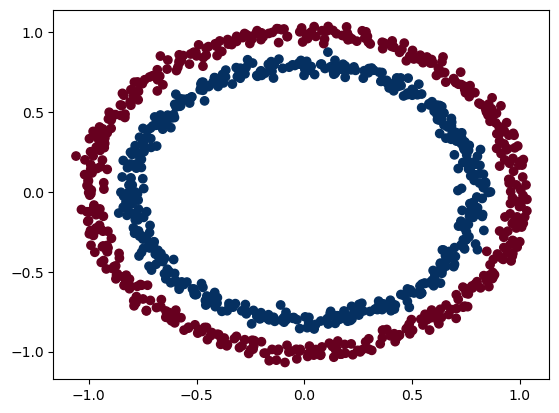

In [6]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [7]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

# 모델 설계

In [56]:
# Build model with non-linear activation function
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=64)
        self.layer_2 = nn.Linear(in_features=64, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=64)
        self.layer_4 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model = CircleModelV2().to(device)
print(model)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


# loss function, optimizer 설정

In [57]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# 모델 학습 및 평가

In [58]:
# Fit the model
torch.manual_seed(42)
epochs = 700

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
        # 2. Calcuate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

        # Print out what's happening
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.62033, Accuracy: 50.00% | Test Loss: 0.49785, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.46816, Accuracy: 50.88% | Test Loss: 0.47693, Test Accuracy: 50.00%
Epoch: 200 | Loss: 0.27080, Accuracy: 61.50% | Test Loss: 0.37730, Test Accuracy: 50.00%
Epoch: 300 | Loss: 0.16647, Accuracy: 56.38% | Test Loss: 0.19114, Test Accuracy: 59.50%
Epoch: 400 | Loss: 0.09476, Accuracy: 60.12% | Test Loss: 0.13902, Test Accuracy: 71.50%
Epoch: 500 | Loss: 0.20344, Accuracy: 89.88% | Test Loss: 0.30994, Test Accuracy: 50.00%
Epoch: 600 | Loss: 0.11468, Accuracy: 61.38% | Test Loss: 0.10988, Test Accuracy: 51.00%


In [59]:
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

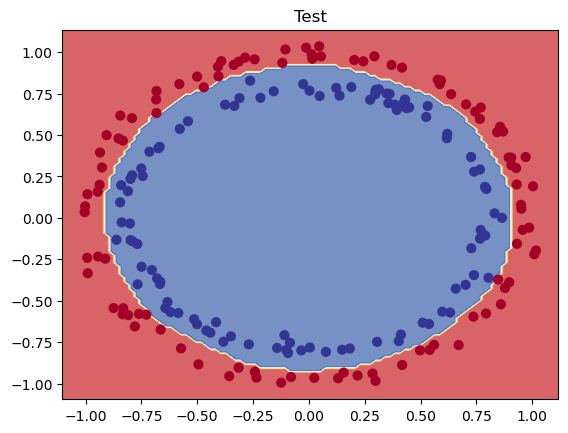

In [60]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)